# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt

# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [3]:
VOCAB = "./notebooks/vocabulary.txt"
SPE_TOKENIZER = "./models/trained/tglang_spe_unigram_10000.model"

USE_SPE = False
WITH_VOCAB = False
USE_ONMT = True
ONMT_MODE = "conservative"

TRAIN_DATA = "./data/processed/tglang_train.csv"
TEST_DATA = "./data/processed/tglang_test.csv"

## Text prep

In [4]:
from collections import Counter

### Load data

In [5]:
thestack = pd.read_csv(TRAIN_DATA)
thestack = thestack.loc[~thestack["content"].isna()]
thestack["content"] = thestack["content"].astype(str)
thestack["lang"] = thestack["lang"].astype(str)

thestack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33203 entries, 0 to 33204
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    33203 non-null  object
 1   lang       33203 non-null  object
 2   num_chars  33203 non-null  int64 
 3   num_lines  33203 non-null  int64 
 4   file       33203 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


In [6]:
test_set = pd.read_csv(TEST_DATA)
test_set = test_set.loc[~test_set["content"].isna()]
test_set["content"] = test_set["content"].astype(str)
test_set["lang"] = test_set["lang"].astype(str)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2262 entries, 0 to 2261
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2262 non-null   object
 1   lang       2262 non-null   object
 2   num_chars  2262 non-null   int64 
 3   num_lines  2262 non-null   int64 
 4   file       2262 non-null   object
dtypes: int64(2), object(3)
memory usage: 106.0+ KB


### Load vocab

In [7]:

vocab = Path(VOCAB).read_text().split("\n")

print("Vocab size:", len(vocab))

pprint(random.choices(vocab, k=10))

Vocab size: 1461
['delayed',
 'null',
 'year',
 'control',
 'whose',
 'linkage',
 'policy',
 'pid',
 'subscribe',
 'jno']


### Tokenizer

In [8]:
import functools
import torch
import pyonmttok

In [9]:
from torchtext.transforms import SentencePieceTokenizer

transform_sentpiece = SentencePieceTokenizer(SPE_TOKENIZER)

spe_scripted = torch.jit.script(transform_sentpiece)

In [10]:
onmt_tokenizer = pyonmttok.Tokenizer(mode=ONMT_MODE, case_feature=False)

In [11]:
def check_vocab(x):
    if x in VOCAB:
        return True
    else:
        return False
    
    
def split_text(x, with_vocab=WITH_VOCAB):
    x = x.lower()
    tokens = re.split("[\W']+", x)
    tokens = list(filter(bool, tokens))
    
    if with_vocab:
        tokens = list(filter(check_vocab, tokens))
    return tokens


def tokenize_onmt(text):
    return onmt_tokenizer.tokenize(text)[0]


if USE_ONMT:
    tokenize_text = tokenize_onmt
elif USE_SPE:
    tokenize_text = spe_scripted
else:
    tokenize_text = functools.partial(split_text, with_vocab=WITH_VOCAB)

In [12]:
smp = thestack.sample(2)

for _, row in smp.iterrows():
    tokens = tokenize_text(row["content"])
    print(f"================== {row['lang']} =================", end="\n\n")
    print(row["content"], end="\n\n")
    print("TOKENS:", Counter(tokens), sep="\n", end="\n\n")

================== TGLANG_LANGUAGE_GO =================

	// namespace does not already exist, and that the user can create cluster-wide
	// resources, including ClusterRole, ClusterRoleBinding, and
	// CustomResourceDefinition, as well as namespace-wide resources, including
	// Service, Deployment, and ConfigMap. This check only runs as part of the set
	// of pre-install checks.
	// This check is dependent on the output of KubernetesAPIChecks, so those
	// checks must be added first.
	LinkerdPreInstallChecks CategoryID = "pre-kubernetes-setup"

TOKENS:
Counter({'/': 14, ',': 9, 'and': 3, 'the': 3, 'as': 3, '.': 3, 'of': 3, 'resources': 2, 'including': 2, 'This': 2, 'check': 2, 'checks': 2, '"': 2, 'namespace': 1, 'does': 1, 'not': 1, 'already': 1, 'exist': 1, 'that': 1, 'user': 1, 'can': 1, 'create': 1, 'cluster-wide': 1, 'ClusterRole': 1, 'ClusterRoleBinding': 1, 'CustomResourceDefinition': 1, 'well': 1, 'namespace-wide': 1, 'Service': 1, 'Deployment': 1, 'ConfigMap': 1, 'only': 1, '

## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

# from xgboost import XGBClassifier

import itertools

In [14]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, input_fields, preprocessing, vect, est):
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['raw']
        self.preprocessing = preprocessing
        
    def prepare_data(self, is_final):
        # combine fields
        data = thestack.copy()
        data["text"] = thestack.apply(lambda x: " ".join([x[f] for f in self.INPUT_FIELDS]),
                                      axis=1)
        # split into  train and test
        one, self.test_inputs = train_test_split(data, test_size=0.2, random_state=24, shuffle=True,)
        comb_datasets = [one, self.test_inputs] if is_final else [one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['lang']
        self.y_test = self.test_inputs['lang']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['lang'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] == x['true'], axis=1).mean()
        return score
    
    def predict(self, inputs):
        tokens = self.vect.transform(inputs)
        return self.clf.predict(tokens)
        
    @staticmethod
    def score(predictions, gt):
        return (predictions == gt).mean()

### Set hyper-parameters

In [26]:
INPUTS = [
    'content',
#     "punct",
]

PREPROCESSING = [
    'raw',
]

vect_params = dict(
    max_df=0.25, 
    min_df=3,
    max_features=300,
    binary=False, 
    ngram_range=(1,1), 
    stop_words=None,
#     tokenizer= lambda x: re.split(),
    tokenizer=tokenize_text,
    
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [27]:
input_combinations = [INPUTS] #list(itertools.combinations(INPUTS, r=2)) + [INPUTS]

train_params = list(itertools.product( 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

4

### Run experiments

In [28]:
X_test = test_set["content"]
y_test = test_set["lang"]


In [29]:
results = []

for params in notebook_tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    val_score = trainer.run_eval()
    test_score = trainer.score(trainer.predict(X_test), y_test)
    score = (val_score + test_score * 2) / 3
    params += (val_score, test_score, score)
    results.append(params)
                
results = pd.DataFrame(results, columns=['input_fields', 'preprocessing','vect', 'est', 
                                         'val_score', "test_score", "score"])

# experiments:   0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:01<00:03,  1.02s/it]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  50%|██████████████████████████████████████████████████████████████████████████▌                                               

In [30]:
print(results.sort_values('score', ascending=False).to_markdown())

|    | input_fields   | preprocessing   | vect   | est   |   val_score |   test_score |    score |
|---:|:---------------|:----------------|:-------|:------|------------:|-------------:|---------:|
|  1 | ['content']    | raw             | tfidf  | mnb   |    0.67535  |     0.700707 | 0.692255 |
|  3 | ['content']    | raw             | bow    | mnb   |    0.666918 |     0.635721 | 0.64612  |
|  0 | ['content']    | raw             | tfidf  | cnb   |    0.522211 |     0.4916   | 0.501804 |
|  2 | ['content']    | raw             | bow    | cnb   |    0.492847 |     0.447392 | 0.462544 |


### Review errors

In [31]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [32]:
best_params = results.sort_values("score", ascending=False).iloc[0].to_dict()
best_params.pop("score"), best_params.pop("val_score"), best_params.pop("test_score")

(0.6922549250511906, 0.6753500978768258, 0.7007073386383731)

In [33]:
trainer = Trainer(**best_params)
s = trainer.run_eval(final=False)
print(s)

/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.6753500978768258


#### Classification report

In [34]:
from sklearn.metrics import classification_report

In [35]:

test_pred = trainer.predict(X_test)

is_wrong = test_pred != y_test

errors = test_set.loc[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/var/folders/fg/vxz9bx5n1vvb2p8k4cr_wc9h0000gp/T/ipykernel_19747/2620725147.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['predicted'] = test_pred[is_wrong]


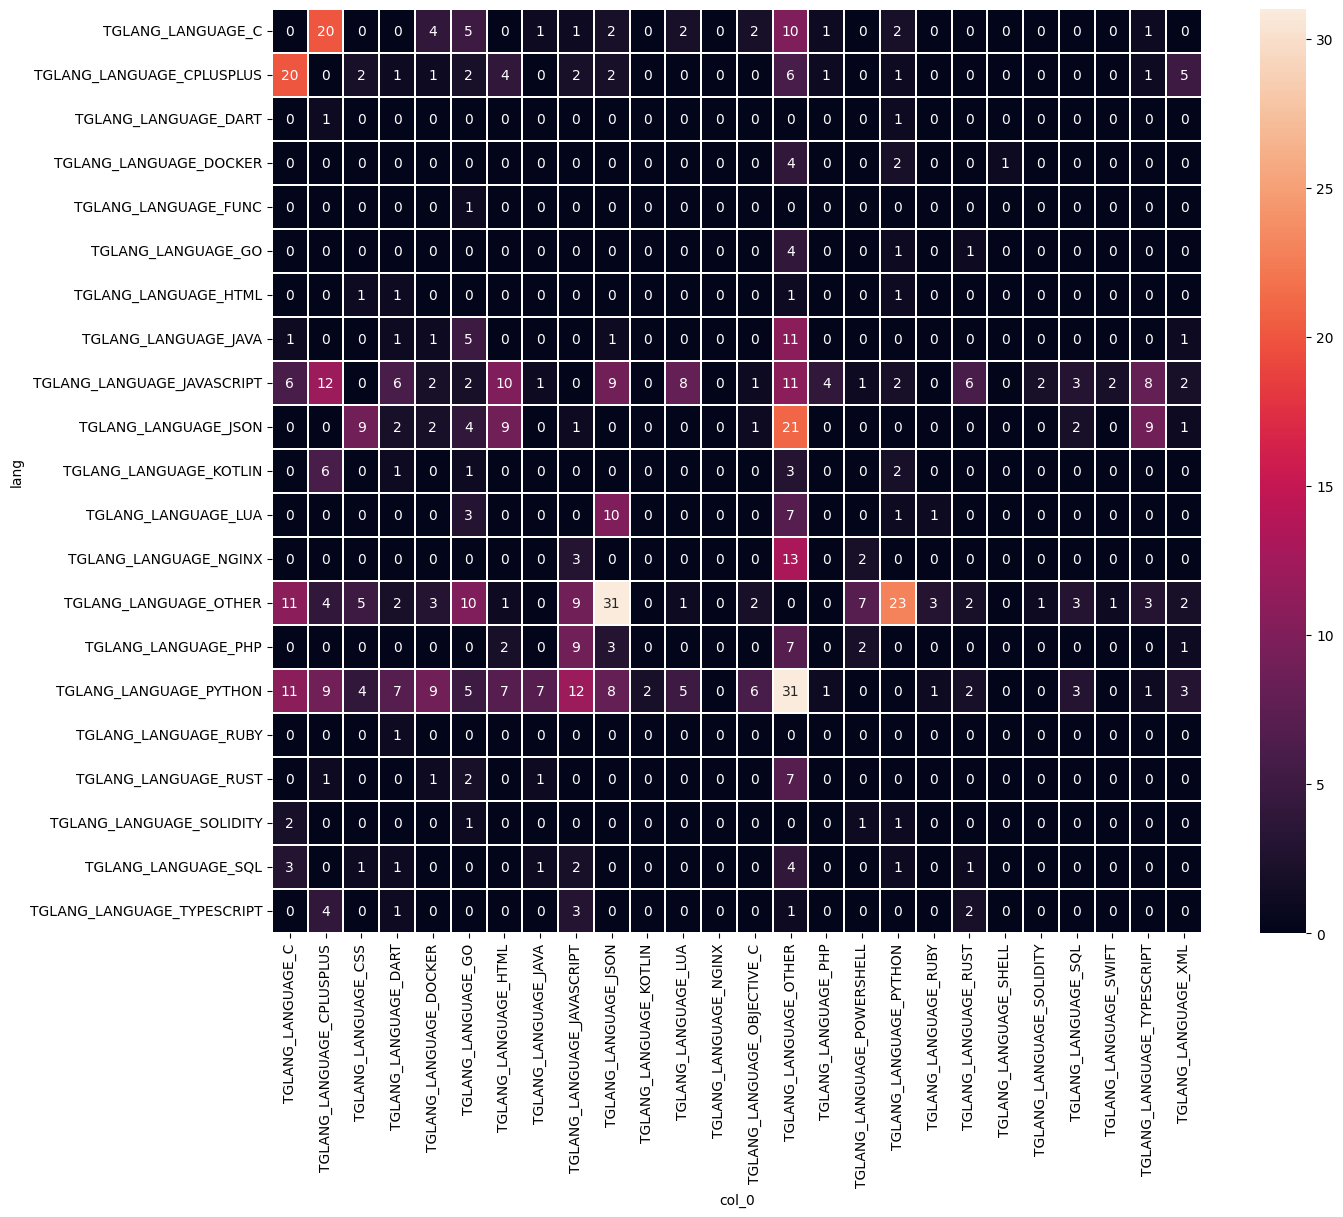

In [36]:
ct = pd.crosstab(y_test, test_pred)
for i,k in ct.iterrows():
    k[i] = 0


plt.figure(figsize=(15,12))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [37]:
metrics = pd.DataFrame(classification_report(y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                            |   precision |   recall |   f1-score |     support |
|:---------------------------|------------:|---------:|-----------:|------------:|
| TGLANG_LANGUAGE_FUNC       |   0         | 0        |   0        |    1        |
| TGLANG_LANGUAGE_DART       |   0.0769231 | 0.5      |   0.133333 |    4        |
| TGLANG_LANGUAGE_SQL        |   0.153846  | 0.125    |   0.137931 |   16        |
| TGLANG_LANGUAGE_C          |   0.19403   | 0.203125 |   0.198473 |   64        |
| TGLANG_LANGUAGE_DOCKER     |   0.178571  | 0.416667 |   0.25     |   12        |
| TGLANG_LANGUAGE_RUBY       |   0.166667  | 0.5      |   0.25     |    2        |
| TGLANG_LANGUAGE_TYPESCRIPT |   0.206897  | 0.352941 |   0.26087  |   17        |
| TGLANG_LANGUAGE_JAVASCRIPT |   0.432432  | 0.246154 |   0.313725 |  130        |
| macro avg                  |   0.356906  | 0.35388  |   0.324128 | 2262        |
| TGLANG_LANGUAGE_LUA        |   0.384615  | 0.3125   |   0.344828 |   32        |
| TG

#### Errors

In [38]:
TRUE_CLASS = "TGLANG_LANGUAGE_PYTHON"
PRED_CLASS = None  # "TGLANG_LANGUAGE_C"

class_errors = test_set.loc[(y_test == TRUE_CLASS) & 
                                   ((test_pred == PRED_CLASS ) if PRED_CLASS else (test_pred != TRUE_CLASS))
                                  ]

for _, row in class_errors.iterrows():
    print("="*10, row["lang"], "="*10, end="\n\n")
    print(row["content"], end="\n\n")
    tokens = tokenize_text(row["content"],)
    print("VOCAB:", Counter([t for t in tokens if t in trainer.vect.vocabulary_]))
    
# print(*class_errors["content"].sample(3).tolist(), sep="\n\n=================================\n\n")

========== TGLANG_LANGUAGE_PYTHON ==========

bash
   pip install virtualenv

VOCAB: Counter({'install': 1})
========== TGLANG_LANGUAGE_PYTHON ==========

import random
import time
from ZoomBot import ZoomBot
from russian_names import RussianNames
from tqdm import tqdm
from threading import Thread
from russian_names import RussianNames

VOCAB: Counter({'import': 6})
========== TGLANG_LANGUAGE_PYTHON ==========

    while True:
        if random.random() < 0.05:
            bots[random.randint(0, len(bots) - 1)].turn_camera()
            bots[random.randint(0, len(bots) - 1)].turn_microphone()
    time.sleep(30)
    for bot in bots:
        bot.disconnect()

VOCAB: Counter({'[': 2, '0': 2, '-': 2, '1': 2, ']': 2, 'if': 1, '<': 1, '30': 1, 'for': 1, 'in': 1})
========== TGLANG_LANGUAGE_PYTHON ==========

        bot.close()
names = ["Вера Ли", "Анна Романова", "Ульяна Борко ", "Макс Гаврилов", "Сергей Назаренко", "Надежда Горбунова",
         "Владислав Цветков ", "Misha Makarov", "Алла 

#### Vocab

In [39]:
trainer.vect.vocabulary_

{'#': 1,
 'This': 61,
 'file': 131,
 'the': 249,
 'files': 132,
 '`': 70,
 'to': 254,
 'this': 251,
 "'": 5,
 's': 226,
 '@': 37,
 'param': 210,
 '[': 65,
 'String': 56,
 ']': 67,
 'The': 60,
 'from': 139,
 'a': 71,
 'string': 240,
 'return': 224,
 '<': 34,
 '>': 35,
 'with': 281,
 '|': 285,
 'value': 271,
 '^': 68,
 'end': 120,
 'options': 204,
 'are': 79,
 '1': 11,
 'If': 46,
 'you': 284,
 'new': 192,
 'which': 278,
 't': 243,
 'in': 157,
 'by': 92,
 'default': 109,
 '$': 2,
 'location': 180,
 'for': 137,
 '-': 8,
 'Name': 51,
 '\\': 66,
 'code': 98,
 '*': 6,
 'required': 222,
 'or': 205,
 'software': 232,
 'distributed': 113,
 'under': 262,
 'License': 48,
 'is': 165,
 'on': 203,
 'an': 74,
 'AS': 40,
 'IS': 45,
 'WARRANTIES': 63,
 'OR': 54,
 'OF': 53,
 'ANY': 39,
 'See': 55,
 'and': 75,
 'include': 158,
 'state': 236,
 'be': 87,
 'r': 218,
 'message': 184,
 'line': 176,
 '+': 7,
 'source': 233,
 'address': 72,
 'version': 273,
 'title': 253,
 'true': 258,
 '20': 21,
 'function': 14

## Save models

In [40]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple, Any

In [41]:
LANG_ENUM = Path("./src/tglang/langs_enum_r2.txt").read_text().split('\n')
LANG_ENUM = [l.strip() for l in LANG_ENUM]

In [42]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.clf_labels = clf.classes_.tolist()
        self.target_labels = LANG_ENUM
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [
            self.count_vocab(doc)
            for doc in batch
        ]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgLang(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf):
        super().__init__()
        self.vect = vect
        self.clf = clf
        
        
    def select_top_class(self, probs: torch.Tensor) -> int:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb' and probs.std(0) < 0.0001:
            return 0
        elif self.clf.nb == 'mnb' and probs.max() < 0.001:
            return 0
        max_index = torch.argmax(probs, 0)
        class_label = self.clf.clf_labels[max_index.item()]
        return self.clf.target_labels.index(class_label)
        
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[int]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_class(probs[i]) for i in range(probs.size(0))]
        return top_predictions
    
    
class Tokenizer(nn.Module):
    def forward(self, docs: list[str]) -> list[list[str]]:
        return [tokenize_text(doc) for doc in docs]

### Test

In [43]:

trainer = Trainer(**best_params)
_ = trainer.run_eval(final=True)

tglang = TgLang(
    TextVectorizer(best_params["vect"], trainer.vect),
    NaiveBayes(best_params["est"], trainer.clf),
)

# torchscript
tglang = torch.jit.script(tglang)


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
tokenizer = Tokenizer()
seq = nn.Sequential(
    tokenizer,
    tglang
)


In [48]:

batch = test_set.sample(5)
inputs = batch["content"].tolist()
gt = batch["lang"].tolist()



predictions = seq(inputs)

for inp, out, index in zip(inputs, gt, predictions):
    print(f"Predicted {LANG_ENUM[index]!r}. "
          f"True: {out!r}", 
          end="\n\n")
    print(inp)
    print("="*50, end="\n\n")

Predicted 'TGLANG_LANGUAGE_PYTHON'. True: 'TGLANG_LANGUAGE_PYTHON'

student_description = [student_1_description,student_2_description]
for sample in student_description:
    response = openai.ChatCompletion.create(
        model = 'gpt-3.5-turbo',
        messages = [{'role': 'user', 'content': sample}],
        functions = student_custom_functions,
        function_call = 'auto'
    )
    # Loading the response as a JSON object
    json_response = json.loads(response['choices'][0]['message']['function_call']['arguments'])
    print(json_response)

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_OTHER'

EOS: 94% 6%
ETH: 96% 4%
LTC: 97% 3%
ZEC: 82% 18%
ETC: 93% 7%
DSH: 77% 23%
BCH: 50% 50%
NEO: 50% 50%
XRP: 50% 50%
XTZ: 50% 50%
BSV: 50% 50%

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_OTHER'

https://t.me/penwritebot/?start=6436b4f493570

Predicted 'TGLANG_LANGUAGE_HTML'. True: 'TGLANG_LANGUAGE_PYTHON'

    return chat_id
# Mengirim pesan ke channel Telegram
def

### Final training, convert and save

In [49]:

path = 'models/trained/tglang.pt'
# tokenizer_path = path.replace("tglang.pt", "tglang_tokenizer.pt")
torch.jit.save(tglang, path)
# torch.jit.save(spe_scripted, tokenizer_path)
print('saved to', path)

saved to models/trained/tglang.pt


#### Test jit

In [50]:
# tokenizer = torch.jit.load(tokenizer_path)
model = torch.jit.load(path)

model

RecursiveScriptModule(
  original_name=TgLang
  (vect): RecursiveScriptModule(original_name=TextVectorizer)
  (clf): RecursiveScriptModule(original_name=NaiveBayes)
)

##### Check other

In [51]:

model_input = test_set[test_set["lang"] == LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_OTHER ==========
5.45 °C        
       ☀️ ясно

========== TGLANG_LANGUAGE_OTHER ==========
5M:    10%   $2.37K    9/0   
1H:   157%   $20.6K   85/1   
1D:   157%   $20.6K   85/1

========== TGLANG_LANGUAGE_CSS ==========
❣️En yeni oyunlar ve yüksek oranlı bahis seçenekleri PronetGaming farkı ile #Favoribahis'te.!

========== TGLANG_LANGUAGE_OTHER ==========
Vol:  $119.6K



##### Check lang

In [52]:

model_input = test_set[test_set["lang"] != LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_OBJECTIVE_C ==========
# Увеличиваем max_count: max_count = max_count + data[i][0] * count_w
# Уменьшаем count_b: count_b = count_b - count_w
# [5][4] [4][]  [4][] - count_b = 2
# 3 
# data[i][1] < count_w: [2, 2]
# Т.к. за цену 2 можно разместить на 2 недели, то
# Увеличиваем max_count: max_count = max_count + data[i][0] * data[i][1]
# Уменьшаем count_b: count_b = count_b - data[i][1]
#[5][4]  [4][2]  [4][2] - count_b = 0 -> break

========== TGLANG_LANGUAGE_C ==========
      // Buttons for pagination
      const paginationKeyboards = createButtons(ctx.session.page, products.length, limit)
      await ctx.reply("<b>Mahsulotlar </b> ", {
        parse_mode: "HTML",
        ...paginationKeyboards

========== TGLANG_LANGUAGE_PHP ==========
/**
     * The bindings for the query.
     *
     * @var array
     */
    protected $bindings;
 
    /**
     * Create a new query exception instance.
     *
     * @param  string  $sql
     * @param  array  $bindings
    

### Check file sizes

In [53]:
!du -h models/trained/* | sort -nr

896K	models/trained/tglang.pt
440K	models/trained/tglang_spe_word_10000.torchscript
436K	models/trained/tglang_spe_word_10000.model
384K	models/trained/tglang_tokenizer.pt
384K	models/trained/tglang_spe_unigram_10000.torchscript
380K	models/trained/tglang_spe_unigram_10000.model
256K	models/trained/tglang_spe_word_1000.torchscript
256K	models/trained/tglang_spe.torchscript
256K	models/trained/tglang_spe.model
252K	models/trained/tglang_spe_word_1000.model
244K	models/trained/tglang_spe_unigram_1000.model
212K	models/trained/tglang_spe_word_10000.vocab
156K	models/trained/tglang_spe_unigram_10000.vocab
 20K	models/trained/tglang_spe_word_1000.vocab
 20K	models/trained/tglang_spe.vocab
 16K	models/trained/tglang_spe_unigram_1000.vocab
1.1M	models/trained/tokenizer.json
